# Example using HBV model in eWaterCycle

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# general eWC
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

Install required plugin with pip:

```console
pip install ewatercycle-HBV
```

## set up paths

In [3]:
path = Path.cwd()
forcing_path = path / "Forcing"

## add parameter info

Array of initial storage terms - we keep these constant for now: <br>
                Si,  Su, Sf, Ss


In [4]:
s_0 = np.array([0,  100,  0,  5])

Array of parameters min/max bounds as a reference: <br>
Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks

In [5]:
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]

Set initial as mean of max,min

In [6]:
par_0 = (p_min_initial + p_max_initial)/2

Specify start and end date

In [7]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"
HRU_id = 2479155
alpha = 1.2626

## Forcing

In [8]:
from ewatercycle_HBV.forcing import HBVForcing

we use camels forcing as an example, which is fully integrated [Newman, 2014](https://gdex.ucar.edu/dataset/camels.html)

In [9]:
camels_forcing = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'0{HRU_id}_lump_cida_forcing_leap.txt',
                          alpha= alpha
                          )

## Setting up the model

In [10]:
from ewatercycle.models import HBV

In [11]:
model = HBV(forcing=camels_forcing)

In [12]:
config_file, _ = model.setup(
            parameters=','.join([str(p) for p in par_0]),
    initial_storage=','.join([str(s) for s in s_0]),
           )

In [13]:
model.initialize(config_file)

## Running model

In [14]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q"))
    time.append(pd.Timestamp(model.time_as_datetime.date()))

After running the model: finalize to shut everything down

In [15]:
model.finalize()

## Process results:

In [16]:
df = pd.DataFrame(data=Q_m,columns=["Modeled discharge"],index=time)

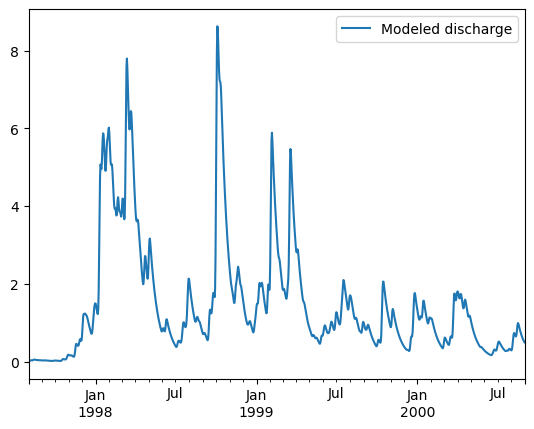

In [17]:
fig, ax = plt.subplots(1,1)
df.plot(ax=ax,label="Modeled discharge HBV-bmi")
ax.legend(bbox_to_anchor=(1,1));